In [1]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
n_eval_trials = 1
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trial_groups = int(np.floor(10 / n_eval_trials))
n_trials = n_trial_groups * n_eval_trials


# Initialize dicts.
report = {}


model_names = [
    "icassp-convnet",
    "pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    #"pcen-addntt-convnet_aug-all-but-noise",
    #"pcen-ntt-convnet_aug-all-but-noise",
    #"icassp-convnet_aug-all",
]

# Loop over augmentations.
for model_name in model_names:
    if model_name == "pcen-add-convnet_aug-all-but-noise":
        model_suffix = "-nomindist"
    else:
        model_suffix = ""

    # Initialize dictionaries
    aug_report = {
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "val-AUPRC": {},
        "val-F": {},
    }

    ###############################   VALIDATION   #################################
    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_dir = os.path.join(models_dir, model_name)

    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name + model_suffix,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
                val_auprc = 0.0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    val_F_tensor = np.reshape(val_f1_scores, (6, n_eval_trials, n_trial_groups))
    val_F_trials = np.zeros((6, n_eval_trials))
    val_F_precisions = np.zeros((6, n_eval_trials))
    val_F_recalls = np.zeros((6, n_eval_trials))
    val_F_f1_scores = np.zeros((6, n_eval_trials))
    val_F_thresholds = np.zeros((6, n_eval_trials))
    val_F_threshold_ids = np.zeros((6, n_eval_trials))
    val_F_auprcs = np.zeros((6, n_eval_trials))


    val_AUPRC_tensor = np.reshape(val_auprcs, (6, n_eval_trials, n_trial_groups))
    val_AUPRC_trials = np.zeros((6, n_eval_trials))
    val_AUPRC_precisions = np.zeros((6, n_eval_trials))
    val_AUPRC_recalls = np.zeros((6, n_eval_trials))
    val_AUPRC_f1_scores = np.zeros((6, n_eval_trials))
    val_AUPRC_thresholds = np.zeros((6, n_eval_trials))
    val_AUPRC_threshold_ids = np.zeros((6, n_eval_trials))
    val_AUPRC_auprcs = np.zeros((6, n_eval_trials))


    # Select best n INDEPENDENT trials out of 10.
    # We proceed by groups to guarantee statistical independence.
    # Loop over test units.
    for test_unit_id in range(6):

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):

            best_F_column_id = np.argmax(
                val_F_tensor[test_unit_id, eval_trial_id, :])
            trial_F_id = n_trial_groups * eval_trial_id + best_F_column_id
            
            val_F_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_F_id]
            val_F_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_F_id]
            val_F_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_F_id]
            val_F_trials[test_unit_id, eval_trial_id] =\
                trial_F_id
            val_F_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_F_id]
            val_F_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_F_id]
            val_F_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_F_id]

            best_AUPRC_column_id = np.argmax(
                val_AUPRC_tensor[test_unit_id, eval_trial_id, :])
            trial_AUPRC_id = n_trial_groups * eval_trial_id + best_AUPRC_column_id
            
            val_AUPRC_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_AUPRC_id]
            val_AUPRC_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_AUPRC_id]
            val_AUPRC_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_AUPRC_id]
            val_AUPRC_trials[test_unit_id, eval_trial_id] =\
                trial_AUPRC_id
            val_AUPRC_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_AUPRC_id]
            val_AUPRC_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_AUPRC_id]
            val_AUPRC_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_AUPRC_id]


    aug_report["val-F"] = {
        "P": val_F_precisions,
        "R": val_F_recalls,
        "F": val_F_f1_scores,
        "trials": val_F_trials,
        "thresholds": val_F_thresholds,
        "threshold_ids": val_F_threshold_ids,
        "AUPRC": val_F_auprcs
    }


    aug_report["val-AUPRC"] = {
        "P": val_AUPRC_precisions,
        "R": val_AUPRC_recalls,
        "F": val_AUPRC_f1_scores,
        "trials": val_AUPRC_trials,
        "thresholds": val_AUPRC_thresholds,
        "threshold_ids": val_AUPRC_threshold_ids,
        "AUPRC": val_AUPRC_auprcs
    }


    ###############################   TEST   #################################

    for mode in ["F", "AUPRC"]:
        val_mode = "val-" + mode
        test_mode = "test-CV-" + mode

        aug_report[test_mode] = {
            "CV-P": np.zeros((n_eval_trials,)),
            "CV-R": np.zeros((n_eval_trials,)),
            "CV-F": np.zeros((n_eval_trials,)),
            "CV-AUPRC": np.zeros((n_eval_trials,)),
            "P": np.zeros((n_thresholds, n_eval_trials)),
            "R": np.zeros((n_thresholds, n_eval_trials)),
            "F": np.zeros((n_thresholds, n_eval_trials))
        }

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):
            break_switch = False

            test_tp = np.zeros((n_thresholds,))
            test_fp = np.zeros((n_thresholds,))
            test_fn = np.zeros((n_thresholds,))

            for test_unit_id in range(n_units):

                test_unit_str = units[test_unit_id]
                test_unit_dir = os.path.join(model_dir, test_unit_str)

                trial_id = int(aug_report[
                    val_mode]["trials"][test_unit_id, eval_trial_id])
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    model_name + model_suffix,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = test_tp + np.array(test_metrics_df["True positives"])
                    test_fp = test_fp + np.array(test_metrics_df["False positives"])
                    test_fn = test_fn + np.array(test_metrics_df["False negatives"])
                except:
                    print(test_metrics_name)
                    break_switch = True


            if break_switch:
                test_auprc = 0.0
                test_p = np.zeros((n_thresholds,))
                test_r = np.zeros((n_thresholds,))
                test_f = np.zeros((n_thresholds,))
                test_threshold = 1.0
                test_threshold_id = 0
                test_auprc = 0.0
            else:
                test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
                test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
                test_f = 2*test_p*test_r / (np.finfo(float).eps+(test_p+test_r))
                test_threshold = aug_report[
                    val_mode]["thresholds"][test_unit_id, eval_trial_id]
                test_threshold_id = int(aug_report[
                    val_mode]["threshold_ids"][test_unit_id, eval_trial_id])
                test_p_ = np.array([1.0] + list(test_p) + [0.0])
                test_r_ = np.array([0.0] + list(test_r) + [1.0])
                test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)



            aug_report[test_mode]["CV-P"][eval_trial_id] = test_p[test_threshold_id]
            aug_report[test_mode]["CV-R"][eval_trial_id] = test_r[test_threshold_id]
            aug_report[test_mode]["CV-F"][eval_trial_id] = test_f[test_threshold_id]
            aug_report[test_mode]["CV-AUPRC"][eval_trial_id] = test_auprc


            aug_report[test_mode]["P"][:, eval_trial_id] = test_p
            aug_report[test_mode]["R"][:, eval_trial_id] = test_r
            aug_report[test_mode]["F"][:, eval_trial_id] = test_f
            

        all_test_recalls = np.array(list(np.sort(np.ravel(aug_report[test_mode]["R"]))))
        interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

        for eval_trial_id in range(n_eval_trials):
            precision_interpolator = scipy.interpolate.interp1d(
                np.array([0.0] + list(aug_report[test_mode]["R"][:, eval_trial_id]) + [1.0]),
                np.array([1.0] + list(aug_report[test_mode]["P"][:, eval_trial_id]) + [0.0]))
            interpolated_precisions[:, eval_trial_id] =\
                np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

        interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
        aug_report[test_mode]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
        aug_report[test_mode]["interpolated_R"] = interpolated_recalls
        aug_report[test_mode]["interpolated_F"] =\
            (2*aug_report[test_mode]["interpolated_P"]*aug_report[test_mode]["interpolated_R"][:, np.newaxis]) /\
            (np.finfo(float).eps+aug_report[test_mode]["interpolated_P"]+aug_report[test_mode]["interpolated_R"][:, np.newaxis])
            

    report[model_name] = aug_report


/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

In [2]:
## SPECTRAL FLUX
import h5py
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import sys
sys.path.append('../src')
import localmodule
from tqdm import tqdm

# Define directory of spectral flux ODFs.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
units = localmodule.get_units()
n_units = len(units)
sf_dir = os.path.join(data_dir,
    "_".join([dataset_name, "spectral-flux"]))


# Define constants.
sf_sr = 22050
sf_hop_length = 512
n_thresholds = 100
min_dist = 4
tolerance = 0.5


# Define array of thresholds.
thresholds = np.linspace(0.0, 0.5, n_thresholds)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))


In [ ]:
# Loop over units.
for unit_id, unit_str in enumerate(units):

    # Load onset detection function.
    odf_path = os.path.join(sf_dir, unit_str + ".hdf5")
    odf_file = h5py.File(odf_path, "r")
    odf = odf_file["spectral-flux_odf"].value
    odf = np.ravel(odf)
    odf_file.close()

    # Load annotation.
    annotation_path = os.path.join(
        annotations_dir, unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    # Loop over thresholds.
    for th_id, threshold in tqdm(enumerate(thresholds)):
        # Pick peaks.
        peak_locs = peakutils.indexes(
            odf, thres=threshold, min_dist=4)
        selected = peak_locs * sf_hop_length / sf_sr
        #print(len(selected), len(relevant))
        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)
        #print(len(selected_relevant))
        
        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, unit_id] = true_positives
        fp_matrix[th_id, unit_id] = false_positives
        fn_matrix[th_id, unit_id] = false_negatives
        
sf_total_tps = np.sum(tp_matrix, axis=1)
sf_total_fps = np.sum(fp_matrix, axis=1)
sf_total_fns = np.sum(fn_matrix, axis=1)

sf_total_precisions = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fps)
sf_total_precisions = sf_total_precisions[::-1]
sf_total_recalls = 100.0 * sf_total_tps / (sf_total_tps + sf_total_fns)
sf_total_recalls = sf_total_recalls[::-1]
sf_total_f1_scores = (2*sf_total_precisions*sf_total_recalls) / (sf_total_precisions+sf_total_recalls)

sf_report = {
    "P": sf_total_precisions,
    "R": sf_total_recalls,
    "F": sf_total_f1_scores
}
report["spectral-flux"] = {"test": sf_report}

0it [00:00, ?it/s]

                                   Precision  Recall F1 score   AUPRC
icassp-convnet                        69.92%  51.75%   59.48%  63.65%
pcen-convnet                          35.84%  71.99%   47.85%  51.44%
pcen-convnet_aug-all                  64.53%  77.67%   70.49%  76.40%
pcen-add-convnet_aug-all-but-noise    39.92%  77.64%   52.73%  64.55%


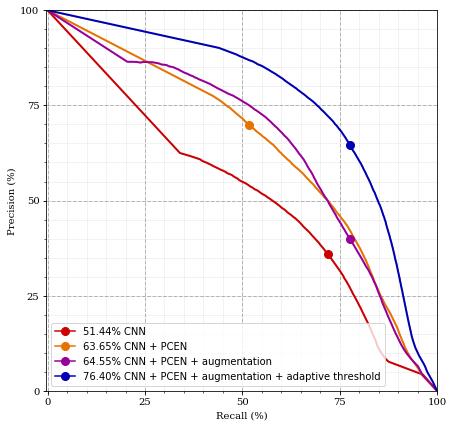

In [3]:
import matplotlib
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 7))

model_names = [
    "icassp-convnet",
    "pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    #"pcen-addntt-convnet_aug-all-but-noise",
    #"pcen-ntt-convnet_aug-all-but-noise",
    #"icassp-convnet_aug-all",
]

model_colors = [
    "#CB0003", 
    "#E67300",
    "#990099",
    "#0000B2",
    "#009900",
    '#008888',
    '#888800',
    '#555555',
]
model_legends = []

model_captions = {
    "icassp-convnet": "CNN",
    "pcen-convnet": "CNN + PCEN",
    "pcen-convnet_aug-all": "CNN + PCEN + augmentation",
    "pcen-add-convnet_aug-all-but-noise": "CNN + PCEN + augmentation + adaptive threshold",
    #"pcen-addntt-convnet_aug-all-but-noise": "+ mixture of experts",
    #"icassp-add-convnet_aug-all-but-noise": " - PCEN",
    #"pcen-ntt-convnet_aug-all-but-noise": "NTT instead",
    #"icassp-convnet_aug-all": "ICASSP 2018",
}

eval_mode = "test-CV-F"

for model_id, model_name in enumerate(model_names):
    
    model_color = model_colors[model_id]
    
    ax.fill_between(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 25, axis=1),
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 75, axis=1),
        color = model_color,
        alpha = 0.2);

    ax.plot(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 50, axis=1),
        color = model_color,
        linewidth = 2.0
    )
    
    cv_p = np.mean(report[model_name][eval_mode]["CV-P"])
    cv_r = np.mean(report[model_name][eval_mode]["CV-R"])
    cv_f = np.mean(report[model_name][eval_mode]["CV-F"])
    cv_auprc = np.mean(report[model_name][eval_mode]["CV-AUPRC"])
    
    plot_r = [100*cv_r]
    plot_p = [100*cv_p]
    plot_f = 100*cv_f
    plot_auprc = 100 * cv_auprc
    
    ax.plot(plot_r, plot_p, "o", 
            color=model_color,
            markersize=8.0)
    
    model_legend = matplotlib.lines.Line2D([], [], color=model_color, marker='o',
        markersize=8, label="{:5.2f}% ".format(plot_auprc) + model_captions[model_name])
    model_legends.append(model_legend)

    
plt.legend(handles=model_legends)
    
    
############################### AXES AND GRID ###################################

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(map(str, major_ticks), family="serif");
ax.set_xlabel("Recall (%)", family="serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");
ax.set_ylabel("Precision (%)", family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax.set_axisbelow(True)

plt.savefig("spl_fig_precision-recall.png", dpi=500, bbox_inches="tight")
plt.savefig("spl_fig_precision-recall.pdf", bbox_inches="tight")
plt.savefig("spl_fig_precision-recall.svg", bbox_inches="tight")


############################### TABLE ###################################

Ps = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x][eval_mode]["CV-AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
print(pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T)

In [7]:
test_mode = "test-CV-F" 

Ps = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T

,Precision,Recall,F1 score,AUPRC
icassp-convnet,69.92%,51.75%,59.48%,63.65%
pcen-convnet,35.84%,71.99%,47.85%,51.44%
pcen-convnet_aug-all,64.53%,77.67%,70.49%,76.40%
pcen-add-convnet_aug-all-but-noise,39.92%,77.64%,52.73%,64.55%


In [61]:
model_report["val-F"]

{'AUPRC': array([[0.80770894],
        [0.75976261],
        [0.76505489],
        [0.81012648],
        [0.77432281],
        [0.88284816]]), 'F': array([[0.76894082],
        [0.73003938],
        [0.71732077],
        [0.74749914],
        [0.71508973],
        [0.83323801]]), 'P': array([[0.79451628],
        [0.76943396],
        [0.71173416],
        [0.78505011],
        [0.81093449],
        [0.89330764]]), 'R': array([[0.74496056],
        [0.69448229],
        [0.72299578],
        [0.7133765 ],
        [0.63950617],
        [0.78073802]]), 'threshold_ids': array([[ 76.],
        [112.],
        [112.],
        [139.],
        [106.],
        [127.]]), 'thresholds': array([[0.99999369],
        [0.99960189],
        [0.99960189],
        [0.99108749],
        [0.99980047],
        [0.99776128]]), 'trials': array([[7.],
        [3.],
        [8.],
        [9.],
        [6.],
        [9.]])}

In [18]:
model_name = "pcen-add-convnet_aug-all-but-noise"

#for model_name in model_names:



  0%|          | 0/5 [00:00<?, ?it/s]

icassp-convnet



100%|██████████| 5/5 [00:24<00:00,  4.70s/it]


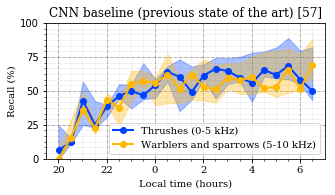

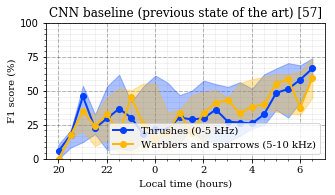


  0%|          | 0/5 [00:00<?, ?it/s]

pcen-convnet



100%|██████████| 5/5 [00:18<00:00,  3.17s/it]


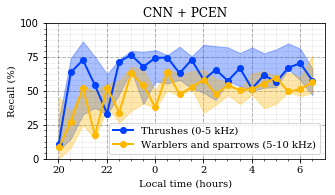

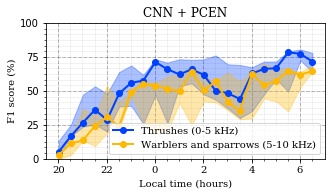


  0%|          | 0/5 [00:00<?, ?it/s]

pcen-convnet_aug-all



100%|██████████| 5/5 [00:13<00:00,  2.44s/it]


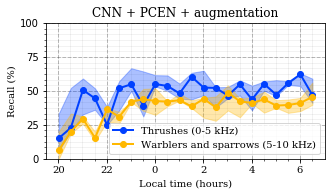

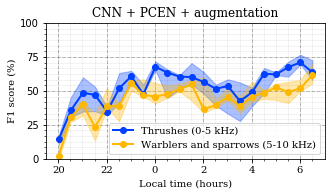


  0%|          | 0/5 [00:00<?, ?it/s]

pcen-add-convnet_aug-all-but-noise



100%|██████████| 5/5 [00:23<00:00,  4.23s/it]


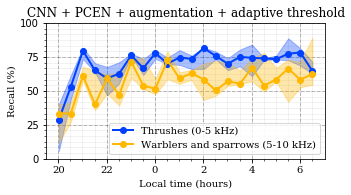

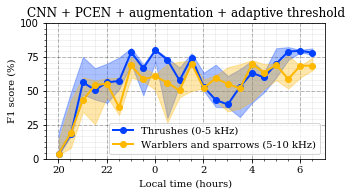

In [63]:
import datetime
import tqdm

tolerance = 0.5 # in seconds
n_hours = 11
bin_hop = 30 # in minutes
n_bins = int(np.round(n_hours * (60/bin_hop)))
bins = (3600 * np.linspace(0, n_hours, 1 + n_bins)).astype('int')
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()


for model_name in model_names:
    print(model_name)

    model_report = report[model_name]
    model_dir = os.path.join(models_dir, model_name)

    thrush_Fs, thrush_Rs, tseep_Fs, tseep_Rs = [], [], [], []

    # We do not include unit10 in the visualization because
    # it is shorter (6 hours) than the other recordings (10 hours).
    for test_unit_id in tqdm.tqdm(range(n_units)[:-1]):    
        # Define directory for trial.
        trial_id = int(model_report["val-F"]["trials"][test_unit_id][0])
        trial_str = "trial-" + str(trial_id)
        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)
        trial_dir = os.path.join(test_unit_dir, trial_str)

        # Load predictions.
        predictions_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "full-predictions.csv"
        ])
        prediction_path = os.path.join(trial_dir, predictions_name)
        prediction_df = pd.read_csv(prediction_path)
        odf = np.array(prediction_df["Predicted probability"])
        timestamps = np.array(prediction_df["Timestamp"])

        # Load threhold.
        threshold = 0.9999
        
        # Select peaks.
        if model_name == "pcen-add-convnet_aug-all-but-noise":
            peak_locations = peakutils.indexes(odf, thres=threshold)
        else:
            peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
        selected = timestamps[peak_locations]

        # Load annotation.
        annotation_path = os.path.join(annotations_dir,
            test_unit_str + ".txt")
        annotation = pd.read_csv(annotation_path, '\t')
        begin_times = np.array(annotation["Begin Time (s)"])
        end_times = np.array(annotation["End Time (s)"])
        relevant = 0.5 * (begin_times + end_times)
        relevant = np.sort(relevant)
        high_freqs = np.array(annotation["High Freq (Hz)"])
        low_freqs = np.array(annotation["Low Freq (Hz)"])
        mid_freqs = 0.5 * (high_freqs + low_freqs)
        n_relevant = len(relevant)

        # Filter by frequency ranges.
        thrush_low = 1000.0
        thrush_high = 5000.0
        thrush_relevant = relevant[(thrush_low < mid_freqs) & (mid_freqs < thrush_high)]
        tseep_low = 5000.0
        tseep_high = 10000.0
        tseep_relevant = relevant[(tseep_low < mid_freqs) & (mid_freqs < tseep_high)]

        # Match events for all calls.
        selected_relevant = mir_eval.util.match_events(relevant, selected, tolerance)
        tp_relevant_ids = list(zip(*selected_relevant))[0]
        tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
        tp_selected_ids = list(zip(*selected_relevant))[1]
        tp_selected_times = [selected[i] for i in tp_selected_ids]

        # Compute number of false positives through time.
        fp_times = [selected[i] for i in range(len(selected)) if i not in tp_selected_ids]
        fp_x, fp_y = np.histogram(fp_times, bins=bins);

        # Match events for Thrush calls. Get number of true positives through time.
        thrush_selected_relevant = mir_eval.util.match_events(
            thrush_relevant, selected, tolerance)
        thrush_tp_relevant_ids = list(zip(*thrush_selected_relevant))[0]
        thrush_tp_relevant_times = [thrush_relevant[i] for i in thrush_tp_relevant_ids]
        thrush_tp_selected_ids = list(zip(*thrush_selected_relevant))[1]
        thrush_tp_selected_times = [selected[i] for i in thrush_tp_selected_ids]
        thrush_tp_x, thrush_tp_y = np.histogram(thrush_tp_relevant_times, bins=bins);

        # Get number of false negatives for Thrush.
        thrush_fn_times = [thrush_relevant[i] for i in range(len(thrush_relevant))
            if i not in thrush_tp_relevant_ids]
        thrush_fn_x, thrush_fn_y = np.histogram(thrush_fn_times, bins=n_bins);

        # Get Thrush precision through time.
        thrush_P = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + fp_x)
        thrush_R = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + thrush_fn_x)
        thrush_F = (2*thrush_P*thrush_R) / (np.finfo(float).eps + thrush_P + thrush_R)

        # Match events for Thrush calls. Get number of true positives through time.
        tseep_selected_relevant = mir_eval.util.match_events(
            tseep_relevant, selected, tolerance)
        tseep_tp_relevant_ids = list(zip(*tseep_selected_relevant))[0]
        tseep_tp_relevant_times = [tseep_relevant[i] for i in tseep_tp_relevant_ids]
        tseep_tp_selected_ids = list(zip(*tseep_selected_relevant))[1]
        tseep_tp_selected_times = [selected[i] for i in tseep_tp_selected_ids]
        tseep_tp_x, tseep_tp_y = np.histogram(tseep_tp_relevant_times, bins=bins);

        # Get number of false negatives for Tseep.
        tseep_fn_times = [tseep_relevant[i] for i in range(len(tseep_relevant))
            if i not in tseep_tp_relevant_ids]
        tseep_fn_x, tseep_fn_y = np.histogram(tseep_fn_times, bins=n_bins);

        # Get Tseep precision through time.
        tseep_P = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + fp_x)
        tseep_R = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + tseep_fn_x)
        tseep_F = (2*tseep_P*tseep_R) / (np.finfo(float).eps + tseep_P + tseep_R)

        thrush_Fs.append(thrush_F)
        tseep_Fs.append(tseep_F)

        thrush_Rs.append(thrush_R)
        tseep_Rs.append(tseep_R)


    utc_timestamp = 1443065462
    utc_datetime = datetime.datetime.fromtimestamp(utc_timestamp)
    utc_offset =\
        utc_datetime.hour +\
        utc_datetime.minute / 60 +\
        utc_datetime.second / 3600
    local_offset = utc_offset - 4
    first_hour = 20

    thrush_R_Q1 = np.percentile(np.stack(thrush_Rs), 25, axis=0)
    thrush_R_med = np.percentile(np.stack(thrush_Rs), 50, axis=0)
    thrush_R_Q3 = np.percentile(np.stack(thrush_Rs), 75, axis=0)

    thrush_F_Q1 = np.percentile(np.stack(thrush_Fs), 25, axis=0)
    thrush_F_med = np.percentile(np.stack(thrush_Fs), 50, axis=0)
    thrush_F_Q3 = np.percentile(np.stack(thrush_Fs), 75, axis=0)


    tseep_R_Q1 = np.percentile(np.stack(tseep_Rs), 25, axis=0)
    tseep_R_med = np.percentile(np.stack(tseep_Rs), 50, axis=0)
    tseep_R_Q3 = np.percentile(np.stack(tseep_Rs), 75, axis=0)

    tseep_F_Q1 = np.percentile(np.stack(tseep_Fs), 25, axis=0)
    tseep_F_med = np.percentile(np.stack(tseep_Fs), 50, axis=0)
    tseep_F_Q3 = np.percentile(np.stack(tseep_Fs), 75, axis=0)



    plt.figure(figsize=(5, 2.5))
    fig = plt.gcf()
    ax1 = plt.gca()

    ax1.fill_between(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_R_Q1[:],
        100 * thrush_R_Q3[:],
        color = "#0040FF",
        alpha = 0.33)

    ax1.plot(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_R_med[:],
        "-o",
        color = "#0040FF",
        linewidth = 2.0)

    ax1.fill_between(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_R_Q1[:],
        100 * tseep_R_Q3[:],
        color = "#FFB800",
        alpha = 0.33)

    ax1.plot(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_R_med[:],
        "-o",
        color = "#FFB800",
        linewidth = 2.0)

    ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
        loc=4, prop={'family':'serif'})

    ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
    ax1.set_xticklabels([str(np.mod(n, 24))
        for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
    ax1.set_xticks(
        np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
        minor=True)
    ax1.set_xlabel("Local time (hours)", family="serif")

    ax1.set_ylim(0, 100)
    ax1.set_ylabel("Recall (%)", family="serif")
    ax1.set_yticks(np.linspace(0, 100, 5))
    ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

    ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
    ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
    ax1.set_axisbelow(True)

    if model_name == "icassp-convnet":
        plt.title("CNN baseline (previous state of the art) [57]", family="serif")
    elif model_name == "pcen-convnet":
        plt.title("CNN + PCEN", family="serif")
    elif model_name == "pcen-convnet_aug-all":
        plt.title("CNN + PCEN + augmentation", family="serif")
    elif model_name == "pcen-add-convnet_aug-all-but-noise":
        plt.title("CNN + PCEN + augmentation + adaptive threshold", family="serif")

    plt.savefig("spl_recall-time_" + model_name + ".png", dpi=500, bbox_inches="tight")
    plt.savefig("spl_recall-time_" + model_name + ".svg", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(5, 2.5))
    fig = plt.gcf()
    ax1 = plt.gca()

    ax1.fill_between(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_F_Q1[:],
        100 * thrush_F_Q3[:],
        color = "#0040FF",
        alpha = 0.33)

    ax1.plot(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_F_med[:],
        "-o",
        color = "#0040FF",
        linewidth = 2.0)

    ax1.fill_between(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_F_Q1[:],
        100 * tseep_F_Q3[:],
        color = "#FFB800",
        alpha = 0.33)

    ax1.plot(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_F_med[:],
        "-o",
        color = "#FFB800",
        linewidth = 2.0)

    ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
        loc=4, prop={'family':'serif'})

    ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
    ax1.set_xticklabels([str(np.mod(n, 24))
        for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
    ax1.set_xticks(
        np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
        minor=True)
    ax1.set_xlabel("Local time (hours)", family="serif")

    ax1.set_ylim(0, 100)
    ax1.set_ylabel("F1 score (%)", family="serif")
    ax1.set_yticks(np.linspace(0, 100, 5))
    ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

    ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
    ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
    ax1.set_axisbelow(True)
    
    if model_name == "icassp-convnet":
        plt.title("CNN baseline (previous state of the art) [57]", family="serif")
    elif model_name == "pcen-convnet":
        plt.title("CNN + PCEN", family="serif")
    elif model_name == "pcen-convnet_aug-all":
        plt.title("CNN + PCEN + augmentation", family="serif")
    elif model_name == "pcen-add-convnet_aug-all-but-noise":
        plt.title("CNN + PCEN + augmentation + adaptive threshold", family="serif")

    plt.savefig("spl_f1score-time_" + model_name + ".png", dpi=500, bbox_inches="tight")
    plt.savefig("spl_f1score-time_" + model_name + ".svg", bbox_inches="tight")
    plt.show()

In [53]:
aug_model_name

NameError: name 'aug_model_name' is not defined

In [16]:
report["pcen-add-convnet_aug-all-but-noise"]["val-F"]["thresholds"]

array([[0.99999369],
       [0.99960189],
       [0.99960189],
       [0.99108749],
       [0.99980047],
       [0.99776128]])

In [55]:
model_names

['icassp-convnet',
 'pcen-convnet',
 'pcen-convnet_aug-all',
 'pcen-add-convnet_aug-all-but-noise']